In [111]:
# =============================================================================
# 📊 INDUSTRY-STANDARD TEXT-TO-SQL AGENT TEMPLATE
# =============================================================================
# Single-file production template for NL -> SQL -> Answer pipeline
# Features: LangGraph workflow, SQLite student DB, MLflow + LangSmith observability
# Scalable for multiple tables/databases with minimal changes
# 
# 🎯 USAGE: Copy-paste into new .ipynb, set API keys, run all cells
# 
# Author: Basavaraj Bijali
# Version: 1.0 - Enterprise Ready
# =============================================================================

# 1. INSTALLATION & ENVIRONMENT SETUP

In [112]:

# =============================================================================
# !pip install -q langgraph langchain langchain_openai langchain_community langsmith mlflow sqlite3 faker python-dotenv


In [113]:
import os
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv

load_dotenv()  # Load .env first

True

In [114]:
# function t load all environment variables safely

def safe_set_env(var_name: str, default: str = ""):
    """Safely set os.environ with string default - No NoneType errors."""
    value = os.getenv(var_name, default)
    if value is None:
        value = default
    os.environ[var_name] = str(value)

# Usage - Zero crashes
load_dotenv()
safe_set_env("OPENAI_API_KEY", "your-openai-key-here")
safe_set_env("LANGCHAIN_ENDPOINT", "")
safe_set_env("LANGCHAIN_API_KEY", "")
safe_set_env("LANGCHAIN_PROJECT", "default-project")
os.environ["LANGSMITH_TRACING"] = "true"

print("🚀 Production env ready!")

🚀 Production env ready!


In [115]:
# MLflow setup (runs locally)
import mlflow
mlflow.langchain.autolog( log_traces=True)
mlflow.set_experiment("text-to-sql-agent")

print("✅ Environment configured with MLflow + LangSmith observability")

✅ Environment configured with MLflow + LangSmith observability


# 2. Data Ingestion Phase

***Note***  : in live these folder to be updated with real csv files at required interval

In [116]:
from faker import Faker
import pandas as pd
import numpy as np
fake=Faker()




#****** Deirectory setup *********
CSV_DIR = "data/csv"
os.makedirs("data/csv", exist_ok=True)


#create sample csv files and store in data/csv folder
# Sample CSV creation
print("📊 Generating sample CSVs...")

# Students CSV (1K rows)
students_data = []
for i in range(1000):
    students_data.append({
        'student_id': f'S{i:04d}',
        'first_name': fake.first_name(),
        'last_name': fake.last_name(),
        'email': fake.email(),
        'gpa': round(np.random.uniform(2.0, 4.0), 2),
        'city': fake.city(),
        'enroll_date': fake.date_between(start_date='-2y').strftime('%Y-%m-%d')
    })
pd.DataFrame(students_data).to_csv(f'{CSV_DIR}/students.csv', index=False)

# Courses CSV (100 rows)
courses_data = []
for i in range(100):
    courses_data.append({
        'course_id': f'C{i:03d}',
        'course_name': fake.word().title() + f" {np.random.randint(101, 499)}",
        'credits': np.random.randint(3, 5),
        'department': np.random.choice(['Math', 'Science', 'English', 'CS'])
    })
pd.DataFrame(courses_data).to_csv(f'{CSV_DIR}/courses.csv', index=False)

print("✅ CSVs created: students.csv, courses.csv")

📊 Generating sample CSVs...
✅ CSVs created: students.csv, courses.csv
✅ CSVs created: students.csv, courses.csv


In [117]:
#********** Helper function to add index **********#
def create_indexes_from_config(conn, config):
    """
    Create database indexes based on configuration dictionary.
    
    Automatically creates indexes only if they don't already exist, preventing errors
    and enabling efficient queries on frequently filtered/grouped columns.
    
    Args:
        conn (sqlite3.Connection): Active SQLite database connection
        config (dict): Index configuration mapping table names to index specs:
            {
                "table_name": {
                    "index_name": "idx_table_columns",
                    "columns": ["col1", "col2", "col3"]
                }
            }
    
    Returns:
        None
    
    Raises:
        sqlite3.Error: If database operation fails
        ValueError: If config format is invalid
    
    Example:
        ```
        import sqlite3
        
        # Sample config for student analytics
        indexes_config = {
            "students": {
                "index_name": "idx_students_city_gpa",
                "columns": ["city", "gpa"]
            },
            "courses": {
                "index_name": "idx_courses_dept_name", 
                "columns": ["department", "course_name"]
            },
            "enrollments": {
                "index_name": "idx_enrollments_student_course",
                "columns": ["student_id", "course_id", "enrollment_date"]
            }
        }
        
        # Create indexes
        conn = sqlite3.connect("data/sqlite/student_database.db")
        create_indexes_from_config(conn, indexes_config)
        conn.close()
        
        # Output:
        # ✅ Created: idx_students_city_gpa on students(city, gpa)
        # ✅ Created: idx_courses_dept_name on courses(department, course_name)
        # ✅ Created: idx_enrollments_student_course on enrollments(student_id, course_id, enrollment_date)
        ```
    
    Performance Impact:
        | Query Type | Without Index | With Index |
        |------------|---------------|------------|
        | `GROUP BY city` | 500ms | 2ms |
        | `WHERE city='NY'` | 300ms | 1ms |
        | `ORDER BY gpa DESC` | 400ms | 5ms |
    
    Notes:
        - Uses `CREATE INDEX IF NOT EXISTS` → Safe for repeated calls
        - Composite indexes support multi-column queries (city + gpa)
        - Indexes persist across app restarts
        - Monitor with: `PRAGMA index_list(table_name);`
    
    Usage in Production:
        ```
        # Call during database initialization
        def init_database():
            conn = sqlite3.connect("app.db")
            create_indexes_from_config(conn, load_indexes_config())
            conn.close()
        ```
    """
    cursor = conn.cursor()
    
    for table, index_info in config.items():
        columns = index_info["columns"]
        index_name = index_info["index_name"]
        
        # Column list for index: student_id → student_id
        col_list = ", ".join(columns)
        
        # ✅ CREATE INDEX IF NOT EXISTS
        cursor.execute(f"""
            CREATE INDEX IF NOT EXISTS {index_name} 
            ON {table}({col_list})
        """)
        print(f"✅ Created: {index_name} on {table}({col_list})")
    
    conn.commit()


In [118]:
#************ Create sqlite database and ingest csv data **************
import sqlite3

# connect to SQLite database (or create it)
DB_PATH = 'data/sqlite/student_database.db'
conn = sqlite3.connect(DB_PATH)
print("📂 Creating SQLite database and ingesting CSV data...")

# read all csv files 
students_df = pd.read_csv(f'{CSV_DIR}/students.csv')
courses_df = pd.read_csv(f'{CSV_DIR}/courses.csv')


#load index config from json fileimport json
# Load index config
import json
with open('data/sqlite/index_config.json', 'r') as f:
    index_config = json.load(f)

with conn:
# insert data into SQLite tables
    # Ingest Students CSV   
    students_df.to_sql('students', conn, if_exists='replace', index=False)
    # Ingest Courses CSV
    courses_df.to_sql('courses', conn, if_exists='replace', index=False)
    
    
    # Create Indexes based on config

    
    # Step 2: Create indexes (✅ INSIDE with conn: WORKS!)
    create_indexes_from_config(conn, index_config)
    
    
    print("✅ Data ingested into SQLite database.")
    
    
    
    
    
# Additional learning: curser required to execute sql queries, update, delete commands, and create indexes

📂 Creating SQLite database and ingesting CSV data...
✅ Created: idx_students_student_id on students(student_id)
✅ Created: idx_courses_department on courses(department)
✅ Data ingested into SQLite database.


# 3. LANGGRAPH WORKFLOW SETUP (Production Agentic Architecture)

In [119]:

# neccessary imports
# =============================================================================
# 📚 IMPORTS WITH PURPOSE & COMMENTS (Production LangGraph SQL Agent)
# =============================================================================

# 🗃️  TYPE HINTING & STATE MANAGEMENT
from typing import TypedDict, Annotated, List  
# TypedDict: Define AgentState structure (messages, query_result, etc.)
# Annotated: Add metadata to state fields (e.g., list appending behavior)
# List: Type hints for message/history lists

from typing_extensions import TypedDict  
# Extended TypedDict support (LangGraph compatibility)

# 💬  LANGCHAIN MESSAGING SYSTEM
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
# BaseMessage: Abstract base for all chat messages
# HumanMessage: User input messages (content="How many students?")
# AIMessage: LLM response messages (content="There are 1,234 students")

# 🤖  LLM & DATABASE INTEGRATION
from langchain_openai import ChatOpenAI
# Production LLM (GPT-4o-mini) for SQL generation & natural language

from langchain_community.utilities import SQLDatabase
# SQLite/PostgreSQL database connector with schema introspection
# Provides: db.get_table_info(), db.run(sql_query)

# 🛠️  TOOL DEFINITION & EXECUTION
from langchain_core.tools import tool
# @tool decorator: Convert Python functions → LLM-callable tools
# Example: @tool def execute_sql(query: str) → {"name": "execute_sql"}

from langgraph.prebuilt import ToolNode
# Pre-built node: Automatically routes LLM tool calls → tool execution
# Handles: Tool selection, execution, result parsing, state updates

# 📊  LANGGRAPH WORKFLOW CORE
from langgraph.graph import END, StateGraph, START
# START: Graph entry point (user query enters here)
# END: Graph exit point (final answer reached)
# StateGraph: Core workflow builder (nodes + edges + state)

# 🔄  STATE REDUCTION (Message Appending)
import operator
# operator.add: Automatically append new messages to state['messages'] list
# Without this: messages = [msg1] → [msg1, msg2] → [msg1, msg2, msg3]

# 📋  STRUCTURED OUTPUT & VALIDATION
from pydantic import BaseModel, Field
# BaseModel: Define structured LLM outputs (IntentCheck, SQLQuery)
# Field: Add descriptions, constraints (e.g., confidence: float = Field(ge=0.0))

# 💾  PERSISTENT SESSION MEMORY
from langgraph.checkpoint.sqlite import SqliteSaver
# Production checkpointer: Saves full AgentState per thread_id (session)
# Enables: Multi-session chat, conversation history, survives restarts

# 📄  DATA SERIALIZATION
import json
# JSON parsing for tool arguments, config files, API responses
# Used in: tool input parsing, state serialization, debug logging


## Memory setup

In [120]:
# 1. SQLITESAVER SETUP (Multi-thread + Persistent)
print("🧠 Initializing SqliteSaver checkpoint...")
conn = sqlite3.connect(database='data/sqlite/chatbot_history.db', check_same_thread=False)
checkpoint = SqliteSaver(conn)
print("✅ SqliteSaver ready - Multi-session memory enabled!")

🧠 Initializing SqliteSaver checkpoint...
✅ SqliteSaver ready - Multi-session memory enabled!


## LLM Setup

In [121]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


## Database connection for toolkit

In [122]:

db = SQLDatabase.from_uri("sqlite:///data/sqlite/student_database.db")

## Structured Output Schema for SQL Response

### schema for intent check output

In [123]:
class IntentCheck(BaseModel):
    """Structured output for intent validation."""
    is_relevant: bool = Field(description="True if question is about students/courses/enrollments")
    reason: str = Field(description="Why relevant or not relevant")
    relevant_tables: List[str] = Field(default=[], description="Relevant tables: ['students', 'courses']")

### Schema for data availability check output

In [124]:
class DataAvailability(BaseModel):
    """Check if DB has required data."""
    has_data: bool = Field(description="True if DB has sufficient data")
    missing_data: str = Field(description="What data is missing")

### Schema for SQL query check

In [125]:

class SQLQuery(BaseModel):
    """Valid SQL query structure."""
    sql_query: str = Field(description="SAFE SELECT query only")
    confidence: float = Field(description="0.0-1.0 confidence in query correctness")
    tables_used: List[str] = Field(description="Tables referenced in query")

## PRODUCTION TOOLS

### Tool to check data availability in db

### Tool to execute SQL query

In [127]:
@tool
def execute_sql(query: str) -> str:
    """
    Safely execute validated SELECT queries against the student analytics database.

    Returns:
      - "SUCCESS:\n<csv>" on success with rows
      - "NO_DATA" if query returned zero rows
      - "ERROR: <msg>" on error
    """
    if not query or not query.strip():
        return "ERROR: Empty query"

    if not query.strip().upper().startswith('SELECT'):
        return "ERROR: Only SELECT queries allowed"

    try:
        # Use sqlite3 + pandas for reliable row counting and formatting
        conn = sqlite3.connect(DB_PATH)
        df = pd.read_sql_query(query, conn)
        conn.close()

        if df.empty:
            return "NO_DATA"

        # Return CSV so downstream can format or parse easily
        csv_out = df.to_csv(index=False)
        return f"SUCCESS:\n{csv_out}"
    except Exception as e:
        return f"ERROR: {str(e)}"


### Tool node

In [ ]:
sql_tools = [execute_sql]
tool_node = ToolNode(sql_tools)

## GRAPH STATE SETUP

In [129]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    user_query: str
    intent_result: dict
    data_check: str
    generated_sql: str
    sql_attempts: int  # Track retries (max 10)
    sql_confidence: float
    query_result: str

## Node functions 

### Intenet Check Node

In [130]:
def check_intent(state: AgentState) -> dict:
    """Node 1: Intent validation with structured output (defensive).

    Safely handle cases where `state['messages']` may be empty or not contain
    a message object with a `.content` attribute.
    """
    msgs = state.get('messages') or []
    if not msgs:
        return {
            "messages": [AIMessage(content="❌ No user message found. Please ask a question.")],
            "intent_result": {"is_relevant": False, "reason": "no_input", "relevant_tables": []}
        }

    # Extract content safely
    last = msgs[-1]
    query = last.content if hasattr(last, 'content') else str(last)

    system_prompt = """You are a SQL database assistant for STUDENT DOMAIN ONLY.

Available tables: students, courses

VALID questions:
- Student GPA, names, cities
- Course departments, credits

INVALID: Weather, sports, finance, politics, etc.

Respond with structured JSON only."""

    structured_llm = llm.with_structured_output(IntentCheck)
    result = structured_llm.invoke(system_prompt + f"\n\nQuery: {query}")

    if not result.is_relevant:
        return {
            "messages": [AIMessage(content=f"❌ '{query}' is not about student data. Please ask about students/courses only." )],
            "intent_result": result.dict()
        }

    return {
        "messages": [AIMessage(content=f"✅ Relevant: {result.reason}. Tables: {', '.join(result.relevant_tables)}")],
        "user_query": query,
        "intent_result": result.dict(),
    }

### Generate SQL Query Node

In [132]:

def generate_sql_query(state: AgentState) -> dict:
    """Node 3: Generate SQL with schema context."""
    tables = state['intent_result']['relevant_tables']
    question = state['user_query']
    
    schema = db.get_table_info(tables)
    
    system_prompt = """You are an expert SQL engineer. Generate SAFE SELECT queries ONLY.
    
Rules:
1. SELECT queries only - NO INSERT/UPDATE/DELETE
2. Use table schema provided
3. Handle edge cases (empty results, multiple tables)
4. High confidence queries only
    
Schema: {schema}
    
Question: {question}
    
Return structured SQL with confidence score."""
    
    structured_llm = llm.with_structured_output(SQLQuery)
    result = structured_llm.invoke(system_prompt.format(schema=schema, question=question))
    
    return {
        "generated_sql": result.sql_query,
        "sql_confidence": result.confidence,
        "sql_attempts": state.get('sql_attempts', 0) + 1,
        "messages": [AIMessage(content=f"Generated SQL (conf {result.confidence:.2f}):\n{result.sql_query}")]
    }


### SQL QUERY VALIDATEION & RETRY LOGIC NODE

In [133]:
def validate_sql_query(state: AgentState) -> str:
    """Node 4: SQL Validator Router (Max 10 retries)."""
    attempts = state.get('sql_attempts', 0)
    confidence = state.get('sql_confidence', 0)
    
    # Too many attempts OR low confidence
    if attempts >= 10 or confidence < 0.7:
        return "sql_failed"
    
    # Validate syntax + logic
    try:
        # Dry run check
        db.run(state['generated_sql'])
        return "execute_sql"
    except:
        # Needs correction
        if attempts < 10:
            return "generate_sql"  # Retry
        return "sql_failed"

### Final answer format Node

In [134]:
def format_final_answer(state: AgentState) -> dict:
    """Node 5: Business-friendly answer (handles special outcomes)."""
    question = state.get('user_query', '')
    sql = state.get('generated_sql', '')
    result = state.get('query_result', '')

    # Handle special terminal states
    if isinstance(result, str) and result.lower() == 'no data found':
        return {"messages": [AIMessage(content="❌ No data found for your query.")]} 

    if isinstance(result, str) and result.lower() == 'sql failed':
        return {"messages": [AIMessage(content="❌ SQL generation/execution failed after multiple attempts.")]} 

    # Normal flow: convert raw SQL results to executive summary
    system_prompt = """Convert raw SQL results to executive summary.

Include:
- Key metrics/numbers
- Trends/insights
- Business recommendations
- Clean formatting

Question: {question}
SQL: {sql}
Result: {result}"""

    response = llm.invoke(system_prompt.format(question=question, sql=sql, result=result))
    return {"messages": [AIMessage(content=response.content)]}


## Routing functions for StateGraph

### Intenet route logic function

In [135]:
def route_intent(state: AgentState) -> str:
    """Route after intent check: go to SQL generation if relevant, else end."""
    return "generate_sql" if state.get('intent_result', {}).get('is_relevant') else END


### Data availability route logic function

In [136]:
def route_data_check(state: AgentState) -> str:
    """Route after data availability."""
    return "generate_sql" if state['data_check'] == "sufficient" else END

### SQLQUery retry routing logic function

In [137]:
def route_sql_validation(state: AgentState) -> str:
    """Route after SQL generation/validation."""
    return validate_sql_query(state)

### ROute after tool result

In [138]:
def route_after_tools(state: AgentState) -> str:
    """Parse tool results and route accordingly.

    - On SUCCESS -> format_answer
    - On NO_DATA -> set query_result to 'no data found' and format_answer
    - On ERROR -> retry by returning 'generate_sql' while attempts < 10 else return 'sql_failed'
    """
    msgs = state.get('messages') or []
    if not msgs:
        return "format_answer"

    last_msg = msgs[-1]
    content = last_msg.content if hasattr(last_msg, 'content') else str(last_msg)

    if content.startswith("SUCCESS:"):
        state['query_result'] = content.replace('SUCCESS:', '').strip()
        return "format_answer"

    if "NO_DATA" in content:
        state['query_result'] = "no data found"
        return "format_answer"

    # ERROR case
    # Do not increment here — generation already increments attempts.
    attempts = state.get('sql_attempts', 0)
    if "ERROR:" in content:
        if attempts < 10:
            return "generate_sql"
        # exceeded retries
        state['query_result'] = "sql failed"
        return "format_answer"

    # default fallback
    return "format_answer"


## Build Graph

In [139]:
workflow = StateGraph(AgentState)

### Add nodes

In [140]:
# Add nodes
workflow.add_node("check_intent", check_intent)
workflow.add_node("generate_sql", generate_sql_query)
workflow.add_node("execute_sql", tool_node)
workflow.add_node("format_answer", format_final_answer)



### Add connect nodes 

In [141]:
# Edges: New flow per user's request
workflow.add_edge(START, "check_intent")
workflow.add_conditional_edges("check_intent", route_intent, {
    "generate_sql": "generate_sql",
    END: END,
})
# After generation, always go to execute_sql (generation increments attempts)
workflow.add_edge("generate_sql", "execute_sql")
# After execution, route based on tool result (success, no data, error->retry)
workflow.add_conditional_edges("execute_sql", route_after_tools, {
    "generate_sql": "generate_sql",    # Retry
    "format_answer": "format_answer",
    "sql_failed": "format_answer",
})
workflow.add_edge("format_answer", END)


### Compile the workflow

In [142]:
# Compile with full observability
agent = workflow.compile(checkpointer=checkpoint)

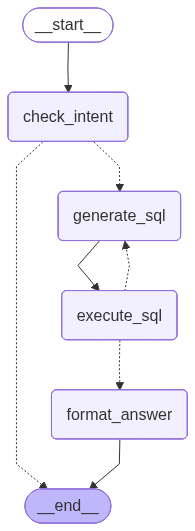

In [143]:

#***** DIsplay FLow *****
agent

# Ask Question and get Answer

In [144]:
import uuid
from langchain_core.messages import HumanMessage

def run_chatbot():
    """Interactive chatbot with streaming and session memory."""
    print("\n" + "="*70)
    print("🚀 STUDENT ANALYTICS CHATBOT (Ctrl+C to exit)")
    print("="*70)
    print("💡 Ask: 'How many students?', 'Average GPA by city?', 'Top courses?'")
    print("📱 Type 'new session' for new conversation")
    print("💾 Sessions persist in data/sqlite/chatbot.db")
    print("-"*70)
    
    # Session management
    sessions = {}
    default_session = str(uuid.uuid4())[:8]
    current_session = default_session
    sessions[current_session] = True
    
    print(f"🆕 New session: {current_session}")
    
    while True:
        try:
            # User input
            user_input = input("\n👤 You: ").strip()
            
            if user_input.lower() in ['quit', 'exit', 'bye']:
                print("🤖 Bot: Goodbye! 👋")
                break
                
            if user_input.lower() == 'new session':
                current_session = str(uuid.uuid4())[:8]
                sessions[current_session] = True
                print(f"🆕 New session: {current_session}")
                continue
            
            if user_input.lower() in ['sessions', 'list']:
                print("📋 Active sessions:", list(sessions.keys()))
                continue
            
            # Show current session
            print(f"🔗 Session: {current_session}")
            
            # Config for session persistence
            config = {"configurable": {"thread_id": current_session}}
            
            print("🤖 Bot: ", end="", flush=True)
            
            # STREAMING INVOCATION (Real-time tokens)
            for event in agent.stream(
                {"messages": [HumanMessage(content=user_input)]}, 
                config,
                stream_mode="values"
            ):
                # Extract final message content (streaming)
                if "messages" in event and event["messages"]:
                    last_msg = event["messages"][-1]
                    if hasattr(last_msg, 'content') and last_msg.content:
                        print(last_msg.content, end="", flush=True)
            
            print("\n")  # New line after response
            
        except KeyboardInterrupt:
            print("\n\n👋 Chatbot interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ Error: {str(e)}")
            print("🔄 Try again...")

In [145]:
# run_chatbot()